In [1]:
import sys
sys.path.append('/workspace')

import os
from pathlib import Path
import gc
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')
import random
import optuna

import h3
import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja

import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier


from sklearn.model_selection import GroupKFold, KFold

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error

from scipy.optimize import minimize

import pretreatment as pre
import model as mdl

In [2]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 56
    AUTHOR = 'miyama'
    COMPETITION = 'PCDUA1'
    DATA_PATH = Path('/workspace/data')
    OOF_DATA_PATH = Path('/workspace/oof')
    MODEL_DATA_PATH = Path('/workspace/models')
    SUB_DATA_PATH = Path('/workspace/submission')
    METHOD_LIST = ['lightgbm', 'xgboost', 'catboost'] #
    seed = 435
    n_folds = 5
    target_col ='money_per_1m2'  ##'money_room' 
    metric = 'RMSE'
    metric_maximize_flag = False
    num_boost_round = 10000
    early_stopping_round = 200
    verbose = 500
    regression_lgb_params = {
        'objective': 'regression',
        'lambda_l1': 1.4e-06,
        'lambda_l2': 1.8e-06,
        'metric': 'rmse',
        'learning_rate': 0.05,
        'seed': seed,
    }
    regression_xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05,
        'colsample_bytree': 0.8, 
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': seed,
    }

    regression_cat_params = {
        'loss_function': 'RMSE',
        'learning_rate': 0.02,
        'depth': 8,
        'iterations': num_boost_round,
        'random_seed': seed,
    }


In [3]:
# polarsの表示設定
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(30)
pl.Config.set_fmt_float("full")
pl.Config.set_float_precision(2)
pl.Config.set_thousands_separator(',')

polars.config.Config

#データの読み込みと前処理

In [5]:
# 読み込み
train_df, test_df = pre.make_df(CFG.DATA_PATH)

In [6]:
# 目的変数の外れ値を補正
train_df = pre.train_outlier_correct(train_df)

# 説明変数の外れ値を補正
train_df = pre.outliner_treatment(train_df)
test_df = pre.outliner_treatment(test_df)

# 単位面積当たり金額を追加
train_df = pre.make_money_per_1m2(train_df)

# 築年数を追加
train_df = pre.calc_buildings_age(train_df)
test_df = pre.calc_buildings_age(test_df)

In [7]:
# ビル平均を追加
train_df, test_df = pre.calc_building_id_mean(train_df, test_df, target_col='money_room')

In [8]:
# H3インデックスカラムを取得
for i in range(5, 8):
    train_df = pre.get_h3_col(train_df, i)
    test_df = pre.get_h3_col(test_df, i)

In [9]:
# タグを展開
train_df = pre.tag_expand(train_df)
test_df = pre.tag_expand(test_df)

In [10]:
# 駅情報を取得
open_data_path = CFG.DATA_PATH / 'station_num_of_person/S12-23_NumberOfPassengers.shp'
station_df = pre.make_station_df(open_data_path)

train_df = pre.get_station_cols(station_df, input_df=train_df)
test_df = pre.get_station_cols(station_df, input_df=test_df)

In [11]:
train_df = pre.get_station_weight_num(train_df, station_df)
test_df = pre.get_station_weight_num(test_df, station_df)

In [12]:
land_kuni_path= CFG.DATA_PATH / 'land_price/L01-22.geojson'
land_ken_path= CFG.DATA_PATH / 'land_price/L02-22.geojson'

train_df = pre.get_land_price(train_df, land_kuni_path, land_ken_path)
test_df = pre.get_land_price(test_df, land_kuni_path, land_ken_path)

# 特徴量選択、ターゲットエンコーディング

In [13]:
use_col = (
    train_df
    .null_count()
    .unpivot()
    .filter(pl.col('value') < 300000)
    .get_column('variable')
    .to_list()
)

In [20]:
exclude_col = [
    'target_ym',
    'building_create_date',
    'building_modify_date',
    'building_name_ruby',
    'homes_building_name',
    'homes_building_name_ruby',
    'lon',
    'lat',
    'building_tag_id',
    'unit_tag_id',
    'snapshot_create_date',
    'new_date',
    'snapshot_modify_date',
    'timelimit_date',
    'post1',
    'post2',
    'addr1_1',
    'addr1_2',
    'addr2_name',
    'addr4_name',
    'nl',
    'el',
    'rosen_name1',
    'eki_name1',
    'rosen_name2',
    'eki_name2',
    'walk_distance2',
    'house_area',
    'flg_new',
    'madori_number_all',
    'madori_kind_all',
    'parking_money_tax',
    'parking_kubun',
    'statuses',
    'money_hoshou_company',
    'station_name_1',
    'station_name_2',
    'lat_lon',
    'madori_from_floor_plan_code',
]

In [21]:
use_col = (
    train_df
    .select(use_col)
    .select(pl.all().exclude(exclude_col))
    .columns
)

In [22]:
CATEGORICAL_FEATURE = ['target_month', 'building_structure', 'dwelling_unit_window_angle', 'usable_status']
TARGET_ENCODING_COL =['station_group_1', 'station_group_2', 'h3_index_res5','h3_index_res6', 'h3_index_res7', 'floor_plan_code']

In [23]:
train_df.head()

money_room,target_ym,building_id,building_status,building_type,building_name,unit_count,full_address,building_structure,floor_count,basement_floor_count,land_youto,land_toshi,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,room_floor,balcony_area,dwelling_unit_window_angle,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,flg_open,flg_own,bukken_type,empty_number,empty_contents,walk_distance1,flg_new,house_kanrinin,money_kyoueki,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_memo,genkyo_code,usable_status,usable_date,school_ele_distance,school_jun_distance,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,free_rent_duration,free_rent_gen_timing,year_built,lon,lat,addr1_1,addr1_2,unit_area,house_area,floor_plan_code,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,room_area,room_count_from_floor_plan_code,madori_from_floor_plan_code,money_per_1m2,target_year,target_month,month_built,buildings_age,money_room_mean_building_id,h3_index_res5,h3_index_res6,h3_index_res7,公営水道210101,井戸210102,水道その他210199,都市ガス210201,プロパンガス210202,ガスその他210299,下水210301,浄化槽210302,汲取210303,排水その他210399,オール電化210401,太陽光発電213101,スマートハウス213301,太陽光発電システム294201,オートロック310101,防犯カメラ310201,管理人常駐310301,24時間有人管理310401,セキュリティ充実313101,エレベーター320101,ごみ出し24時間OK320201,ペット用施設320301,フロントサービス320401,キッズルーム320501,駐車場あり320801,バイク置き場あり320901,駐輪場あり321001,宅配ボックス321101,コンシェルジュサービス323201,デザイナーズ330101,大規模マンション330201,低層マンション330401,タイル貼り330501,外断熱330601,低層住宅地333301,ハイグレードマンション333601,分譲物件333801,免震構造334001,耐震構造334101,制震構造334201,耐震・制震・免震構造334501,角地340301,南道路343201,敷地延長・変形地343301,環境にやさしい393101,子育てに優しい環境393201,スーパー800m以内410101,コンビニ400m以内410201,コンビニ 800ｍ以内410203,小学校800m以内420101,総合病院800m以内423103,公園400m以内423201,フィットネス施設（プール含む）800ｍ以内423301,中学校 800m以内423401,保育園・幼稚園 400m以内423501,複数路線433201,最寄り駅が始発駅433301,専用バス220101,共同バス220102,バスなし220103,専用トイレ220201,共同トイレ220202,トイレなし220203,バス・トイレ別220301,追い焚き220401,シャワー220501,洗髪洗面化粧台220601,温水洗浄便座220701,浴室乾燥機220801,浴室1.6×2.0M以上220901,独立洗面台223101,浴室TV223201,浴室窓有223301,浴室暖房223401,オートバス223501,高温差湯式223601,ガスコンロ設置済230101,電気コンロ230102,IHコンロ230103,コンロ一口230201,コンロ二口230202,コンロ三口230203,コンロ四口以上230204,システムキッチン230401,カウンターキッチン230501,食器洗い乾燥機230601,ディスポーザー230701,給湯230801,冷蔵庫あり230901,浄水器・活水器233101,ガスコンロ233201,冷房240101,ガス暖房240102,石油暖房240103,エアコン240104,床暖房240201,トランクルーム250101,床下収納250201,ウォークインクローゼット250301,パントリー253301,全居室収納253401,クローゼット253501,シューズボックス253601,シューズインクローゼット253701,CATV260101,CS対応260201,BS対応260301,有線放送260401,インターネット対応260501,高速インターネット260502,光ファイバー260503,インターネット利用料無料263101,CATV利用料無料263201,シングル＆DINKS向け283201,メゾネット283401,フローリング290101,専用庭290201,出窓290301,バルコニー290401,二世帯住宅向き290501,バリアフリー290601,フリーアクセス290701,ロフト付き290801,室内洗濯機置場290901,洗濯機置場あり290902,家具・家電付293101,ルーフバルコニー293301,内廊下293401,複層ガラス採用（二重サッシ・防犯サッシ等）293501,テラス293601,吹き抜け293801,和室294001,照明器具付294301,TVモニタ付インターホン310501,分譲賃貸331001,1階の物件340101,2階以上340102,最上階340201,角部屋340401,南向き340501,楽器相談110101,楽器不可110102,事務所可110201,事務所不可110202,二人入居可110301,二人入居不可110302,男性限定110401,女性限定110402,単身者限定110501,単身者希望110502,単身者不可110503,法人限定110601,法人希望110602,法人不可110603,学生限定110701,学生歓迎110702,高齢者限定110801,高齢者歓迎110802,ペット可110901,ペット相談110902,ペット不可110903,建築条件付き111001,建築条件なし111002,家賃カード決済可113301,初期費用カード決済可113302,家賃・初期費用カード決済可113303,ルームシェア可113401,ルームシェア不可113402,セキュリティ会社加入済み113501,フリーレント113601,カスタマイズ可113701,礼金なし120101,敷金なし120201,定期借家権120401,公庫利用可120501,手付金保証あり120601,家賃保証付き120801,保証人要121001,保証人不要121002,特優賃（特定優良賃貸住宅）121101,マンスリー可123201,住宅性能保証制度証明書330801,設計住宅性能評価書334801,耐震基準適合証明書335201,建築確認完了検査済証335501,BELS/省エネ基準適合認定建築物336501,station_group_1,station_group_2,station_group_3,st

In [24]:
use_col = [item for item in use_col if item not in TARGET_ENCODING_COL]

In [25]:
#building_id列を単位として分割する
unique_building_id = train_df.select(pl.col('building_id')).unique()

In [26]:
# クロスバリデーション設定
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

# `unique_building_id` に対して fold を割り当て
folds = np.zeros(len(unique_building_id), dtype=int)
for fold, (_, val_idx) in enumerate(kf.split(unique_building_id)):
    folds[val_idx] = fold

In [27]:
# fold列を'unique_building_id'に対してfoldを割り当て
unique_building_id = unique_building_id.with_columns(pl.Series('fold', folds))

# 元の `train_df` に `fold` 列を追加
train_df = train_df.join(unique_building_id, on="building_id")

In [28]:
# Target Encoding対象列ごとに処理する
for col in TARGET_ENCODING_COL:
    target_encoding_col_name = f'target_encoding_{col}'

    train_df = train_df.with_columns(pl.lit(0).alias(target_encoding_col_name))
    use_col.append(target_encoding_col_name)

    # Target Encoding対象列ごとに処理する
    for fold in range(CFG.n_folds):

        # Target Encodingの値計算
        valid_fold = train_df.filter(pl.col('fold')==fold)

        target_encoding_dict = (
            valid_fold.select(
                pl.col(col),
                pl.col(CFG.target_col).mean().over(col).alias(f'{CFG.target_col}_average'),
            )
            .unique()
            .to_dicts()
        )

        target_encoding_dict = {
            item[col]: item[f'{CFG.target_col}_average'] for item in target_encoding_dict
        }

        # Target Encodingの値格納
        train_df = train_df.with_columns(
            pl.when(pl.col('fold') != fold)
            .then(pl.col(col).replace_strict(target_encoding_dict, default=-1))
            .otherwise(pl.col(target_encoding_col_name))
            .alias(target_encoding_col_name)
        )

    # テストデータのTarget Encoding
    test_target_encoding_dict = (
        train_df.select(
            pl.col(col),
            pl.col(CFG.target_col).mean().over(col).alias(f'{CFG.target_col}_average'),
        )
        .unique()
        .to_dicts()
    )

    test_target_encoding_dict = {
        item[col]: item[f'{CFG.target_col}_average'] for item in test_target_encoding_dict
    }

    test_df = test_df.with_columns(
        pl.col(col).replace_strict(test_target_encoding_dict, default=-1.0)
        .alias(target_encoding_col_name)
    )

In [29]:
features = use_col
features.remove('money_room')
print(features)
print(len(features))

['building_id', 'building_status', 'building_type', 'building_name', 'unit_count', 'full_address', 'building_structure', 'floor_count', 'room_floor', 'dwelling_unit_window_angle', 'flg_open', 'flg_own', 'bukken_type', 'empty_contents', 'walk_distance1', 'money_kyoueki', 'parking_money', 'genkyo_code', 'usable_status', 'convenience_distance', 'super_distance', 'year_built', 'unit_area', 'room_area', 'room_count_from_floor_plan_code', 'money_per_1m2', 'target_year', 'target_month', 'month_built', 'buildings_age', 'money_room_mean_building_id', '公営水道210101', '井戸210102', '水道その他210199', '都市ガス210201', 'プロパンガス210202', 'ガスその他210299', '下水210301', '浄化槽210302', '汲取210303', '排水その他210399', 'オール電化210401', '太陽光発電213101', 'スマートハウス213301', '太陽光発電システム294201', 'オートロック310101', '防犯カメラ310201', '管理人常駐310301', '24時間有人管理310401', 'セキュリティ充実313101', 'エレベーター320101', 'ごみ出し24時間OK320201', 'ペット用施設320301', 'フロントサービス320401', 'キッズルーム320501', '駐車場あり320801', 'バイク置き場あり320901', '駐輪場あり321001', '宅配ボックス321101', 'コンシェルジュサービス3232

In [30]:
features = (
    train_df
    .select(features)
    .select(pl.all().exclude(pl.String))
    .select(pl.all().exclude('building_id','money_per_1m2'))
    .columns
)

#学習前の確認

In [31]:
train_df.select(features).head()

building_status,building_type,unit_count,building_structure,floor_count,room_floor,dwelling_unit_window_angle,flg_open,flg_own,bukken_type,walk_distance1,money_kyoueki,parking_money,genkyo_code,usable_status,convenience_distance,super_distance,year_built,unit_area,room_area,room_count_from_floor_plan_code,target_year,target_month,month_built,buildings_age,money_room_mean_building_id,公営水道210101,井戸210102,水道その他210199,都市ガス210201,プロパンガス210202,ガスその他210299,下水210301,浄化槽210302,汲取210303,排水その他210399,オール電化210401,太陽光発電213101,スマートハウス213301,太陽光発電システム294201,オートロック310101,防犯カメラ310201,管理人常駐310301,24時間有人管理310401,セキュリティ充実313101,エレベーター320101,ごみ出し24時間OK320201,ペット用施設320301,フロントサービス320401,キッズルーム320501,駐車場あり320801,バイク置き場あり320901,駐輪場あり321001,宅配ボックス321101,コンシェルジュサービス323201,デザイナーズ330101,大規模マンション330201,低層マンション330401,タイル貼り330501,外断熱330601,低層住宅地333301,ハイグレードマンション333601,分譲物件333801,免震構造334001,耐震構造334101,制震構造334201,耐震・制震・免震構造334501,角地340301,南道路343201,敷地延長・変形地343301,環境にやさしい393101,子育てに優しい環境393201,スーパー800m以内410101,コンビニ400m以内410201,コンビニ 800ｍ以内410203,小学校800m以内420101,総合病院800m以内423103,公園400m以内423201,フィットネス施設（プール含む）800ｍ以内423301,中学校 800m以内423401,保育園・幼稚園 400m以内423501,複数路線433201,最寄り駅が始発駅433301,専用バス220101,共同バス220102,バスなし220103,専用トイレ220201,共同トイレ220202,トイレなし220203,バス・トイレ別220301,追い焚き220401,シャワー220501,洗髪洗面化粧台220601,温水洗浄便座220701,浴室乾燥機220801,浴室1.6×2.0M以上220901,独立洗面台223101,浴室TV223201,浴室窓有223301,浴室暖房223401,オートバス223501,高温差湯式223601,ガスコンロ設置済230101,電気コンロ230102,IHコンロ230103,コンロ一口230201,コンロ二口230202,コンロ三口230203,コンロ四口以上230204,システムキッチン230401,カウンターキッチン230501,食器洗い乾燥機230601,ディスポーザー230701,給湯230801,冷蔵庫あり230901,浄水器・活水器233101,ガスコンロ233201,冷房240101,ガス暖房240102,石油暖房240103,エアコン240104,床暖房240201,トランクルーム250101,床下収納250201,ウォークインクローゼット250301,パントリー253301,全居室収納253401,クローゼット253501,シューズボックス253601,シューズインクローゼット253701,CATV260101,CS対応260201,BS対応260301,有線放送260401,インターネット対応260501,高速インターネット260502,光ファイバー260503,インターネット利用料無料263101,CATV利用料無料263201,シングル＆DINKS向け283201,メゾネット283401,フローリング290101,専用庭290201,出窓290301,バルコニー290401,二世帯住宅向き290501,バリアフリー290601,フリーアクセス290701,ロフト付き290801,室内洗濯機置場290901,洗濯機置場あり290902,家具・家電付293101,ルーフバルコニー293301,内廊下293401,複層ガラス採用（二重サッシ・防犯サッシ等）293501,テラス293601,吹き抜け293801,和室294001,照明器具付294301,TVモニタ付インターホン310501,分譲賃貸331001,1階の物件340101,2階以上340102,最上階340201,角部屋340401,南向き340501,楽器相談110101,楽器不可110102,事務所可110201,事務所不可110202,二人入居可110301,二人入居不可110302,男性限定110401,女性限定110402,単身者限定110501,単身者希望110502,単身者不可110503,法人限定110601,法人希望110602,法人不可110603,学生限定110701,学生歓迎110702,高齢者限定110801,高齢者歓迎110802,ペット可110901,ペット相談110902,ペット不可110903,建築条件付き111001,建築条件なし111002,家賃カード決済可113301,初期費用カード決済可113302,家賃・初期費用カード決済可113303,ルームシェア可113401,ルームシェア不可113402,セキュリティ会社加入済み113501,フリーレント113601,カスタマイズ可113701,礼金なし120101,敷金なし120201,定期借家権120401,公庫利用可120501,手付金保証あり120601,家賃保証付き120801,保証人要121001,保証人不要121002,特優賃（特定優良賃貸住宅）121101,マンスリー可123201,住宅性能保証制度証明書330801,設計住宅性能評価書334801,耐震基準適合証明書335201,建築確認完了検査済証335501,BELS/省エネ基準適合認定建築物336501,distance_from_station_1,distance_from_station_2,distance_from_station_3,num_of_stations_available,station_num_weight,land_id_1,land_id_2,land_id_3,distance_price_point_1,distance_price_point_2,distance_price_point_3,price_1,price_2,price_3,count_landprice_point,target_encoding_station_group_1,target_encoding_station_group_2,target_encoding_h3_index_res5,target_encoding_h3_index_res6,target_encoding_h3_index_res7,target_encoding_floor_plan_code
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,f64,f64,i64,i32,i8,i8,i32,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32

In [32]:
print(f'ver:{CFG.VER} seed:{CFG.seed} METHOD:{CFG.METHOD_LIST}')
for method in CFG.METHOD_LIST:
    print(method)
    
print(train_df.shape)

ver:56 seed:435 METHOD:['lightgbm', 'xgboost', 'catboost']
lightgbm
xgboost
catboost
(584504, 310)


#学習

In [33]:
# モデルの学習
mdl.Learning(
    train_df,
    features,
    VER=CFG.VER,
    METHOD_LIST=CFG.METHOD_LIST,
    n_folds=CFG.n_folds,
    target_col=CFG.target_col,
    MODEL_DATA_PATH=CFG.MODEL_DATA_PATH,
    seed=CFG.seed,
    OOF_DATA_PATH=CFG.OOF_DATA_PATH,
    verbose=CFG.verbose,
    categorical_feature=CATEGORICAL_FEATURE,
    early_stopping_round=CFG.early_stopping_round,
    regression_lgb_params=CFG.regression_lgb_params,
    regression_xgb_params=CFG.regression_xgb_params,
    regression_cat_params=CFG.regression_cat_params,
    num_boost_round=CFG.num_boost_round,
)

  0%|          | 0/3 [00:00<?, ?it/s]

start fold0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7516
[LightGBM] [Info] Number of data points in the train set: 467716, number of used features: 204
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1740.012103
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 183.835	valid_1's rmse: 189.547
[1000]	training's rmse: 171.146	valid_1's rmse: 184.602
[1500]	training's rmse: 163.685	valid_1's rmse: 182.49
[2000]	training's rmse: 157.908	valid_1's rmse: 181.135
[2500]	training's rmse: 153.168	valid_1's rmse: 180.135
[3000]	training's rmse: 149.038	valid_1's rmse: 179.443
[3500]	training's rms

start fold1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7514
[LightGBM] [Info] Number of data points in the train set: 467656, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1739.683768
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 181.14	valid_1's rmse: 222.03
[1000]	training's rmse: 169.63	valid_1's rmse: 217.434
[1500]	training's rmse: 162.676	valid_1's rmse: 215.26
[2000]	training's rmse: 157.26	valid_1's rmse: 213.989
[2500]	training's rmse: 152.627	valid_1's rmse: 213.016
[3000]	training's rmse: 148.637	valid_1's rmse: 212.493
[3500]	training's rmse: 145.07	valid_1's rmse: 211.946
[4000]	training's rmse: 141.862	va

start fold2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7519
[LightGBM] [Info] Number of data points in the train set: 467835, number of used features: 205
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1740.758834
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 183.614	valid_1's rmse: 190.537
[1000]	training's rmse: 170.998	valid_1's rmse: 185.622
[1500]	training's rmse: 163.762	valid_1's rmse: 183.574
[2000]	training's rmse: 158.062	valid_1's rmse: 182.175
[2500]	training's rmse: 153.388	valid_1's rmse: 181.275
[3000]	training's rmse: 149.225	valid_1's rmse: 180.512
[3500]	training's rm

start fold3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7515
[LightGBM] [Info] Number of data points in the train set: 467275, number of used features: 203
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1741.326810
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 181.816	valid_1's rmse: 200.427
[1000]	training's rmse: 169.376	valid_1's rmse: 195.484
[1500]	training's rmse: 162.107	valid_1's rmse: 193.317
[2000]	training's rmse: 156.767	valid_1's rmse: 192.046
[2500]	training's rmse: 152.193	valid_1's rmse: 191.239
[3000]	training's rmse: 148.233	valid_1's rmse: 190.731
[3500]	training's rm

start fold4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7486
[LightGBM] [Info] Number of data points in the train set: 467534, number of used features: 202
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1739.445176
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 183.058	valid_1's rmse: 194.136
[1000]	training's rmse: 170.29	valid_1's rmse: 189.657
[1500]	training's rmse: 162.855	valid_1's rmse: 187.737
[2000]	training's rmse: 157.099	valid_1's rmse: 186.543
[2500]	training's rmse: 152.464	valid_1's rmse: 185.83
[3000]	training's rmse: 148.389	valid_1's rmse: 185.211
[3500]	training's rmse

 33%|███▎      | 1/3 [11:09<22:19, 669.80s/it]

lightgbm our out of folds CV rmse is 187.4599276877985


start fold0
[0]	train-rmse:759.44427	eval-rmse:756.07607
[500]	train-rmse:173.49408	eval-rmse:189.10854
[1000]	train-rmse:161.32764	eval-rmse:184.01634
[1500]	train-rmse:153.94913	eval-rmse:181.75815
[2000]	train-rmse:148.08239	eval-rmse:180.34888
[2500]	train-rmse:143.06712	eval-rmse:179.35839
[3000]	train-rmse:138.96968	eval-rmse:178.85551
[3500]	train-rmse:135.05330	eval-rmse:178.35220
[4000]	train-rmse:131.50496	eval-rmse:178.07317
[4500]	train-rmse:128.12093	eval-rmse:177.76368
[5000]	train-rmse:125.19306	eval-rmse:177.61429
[5500]	train-rmse:122.35488	eval-rmse:177.42496
[6000]	train-rmse:119.80222	eval-rmse:177.29121
[6500]	train-rmse:117.16251	eval-rmse:177.15807
[7000]	train-rmse:114.83429	eval-rmse:177.08959
[7500]	train-rmse:112.48859	eval-rmse:177.01313
[8000]	train-rmse:110.36351	eval-rmse:176.93895
[8229]	train-rmse:109.39224	eval-rmse:176.95137


start fold1
[0]	train-rmse:755.05745	eval-rmse:773.64179
[500]	train-rmse:172.94525	eval-rmse:222.75582
[1000]	train-rmse:160.90125	eval-rmse:218.27754
[1500]	train-rmse:153.58709	eval-rmse:216.34923
[2000]	train-rmse:147.81244	eval-rmse:215.17150
[2500]	train-rmse:143.02692	eval-rmse:214.35908
[3000]	train-rmse:138.88721	eval-rmse:213.89896
[3500]	train-rmse:135.08662	eval-rmse:213.52336
[4000]	train-rmse:131.70660	eval-rmse:213.18961
[4500]	train-rmse:128.53647	eval-rmse:213.02567
[5000]	train-rmse:125.59364	eval-rmse:212.90206
[5353]	train-rmse:123.66257	eval-rmse:212.86307


start fold2
[0]	train-rmse:758.90109	eval-rmse:758.41347
[500]	train-rmse:173.36990	eval-rmse:190.17029
[1000]	train-rmse:161.45307	eval-rmse:185.25256
[1500]	train-rmse:154.08957	eval-rmse:182.92963
[2000]	train-rmse:148.19606	eval-rmse:181.64027
[2500]	train-rmse:143.32536	eval-rmse:180.80700
[3000]	train-rmse:138.97618	eval-rmse:180.14827
[3500]	train-rmse:135.09695	eval-rmse:179.65440
[4000]	train-rmse:131.66741	eval-rmse:179.34925
[4500]	train-rmse:128.44411	eval-rmse:179.08432
[5000]	train-rmse:125.62415	eval-rmse:178.96613
[5500]	train-rmse:122.68107	eval-rmse:178.76841
[6000]	train-rmse:120.01791	eval-rmse:178.68181
[6500]	train-rmse:117.50364	eval-rmse:178.57188
[7000]	train-rmse:115.14111	eval-rmse:178.48284
[7500]	train-rmse:112.83818	eval-rmse:178.43668
[8000]	train-rmse:110.59123	eval-rmse:178.36863
[8226]	train-rmse:109.63763	eval-rmse:178.37495


start fold3
[0]	train-rmse:760.89479	eval-rmse:749.98639
[500]	train-rmse:173.00500	eval-rmse:199.71198
[1000]	train-rmse:160.93718	eval-rmse:194.98625
[1500]	train-rmse:153.43221	eval-rmse:193.05119
[2000]	train-rmse:147.57185	eval-rmse:191.80316
[2500]	train-rmse:142.73579	eval-rmse:190.86072
[3000]	train-rmse:138.51023	eval-rmse:190.26783
[3500]	train-rmse:134.81106	eval-rmse:189.84757
[4000]	train-rmse:131.39272	eval-rmse:189.57058
[4500]	train-rmse:128.14697	eval-rmse:189.37328
[5000]	train-rmse:125.18564	eval-rmse:189.21737
[5500]	train-rmse:122.38380	eval-rmse:189.08066
[6000]	train-rmse:119.68413	eval-rmse:188.92994
[6500]	train-rmse:117.14018	eval-rmse:188.82637
[7000]	train-rmse:114.76695	eval-rmse:188.76129
[7124]	train-rmse:114.15257	eval-rmse:188.76505


start fold4
[0]	train-rmse:759.54465	eval-rmse:755.83485
[500]	train-rmse:173.00134	eval-rmse:195.45497
[1000]	train-rmse:160.56922	eval-rmse:190.70777
[1500]	train-rmse:152.96905	eval-rmse:188.84615
[2000]	train-rmse:147.22659	eval-rmse:187.89580
[2500]	train-rmse:142.31133	eval-rmse:187.16446
[3000]	train-rmse:138.14160	eval-rmse:186.74062
[3500]	train-rmse:134.34832	eval-rmse:186.41855
[4000]	train-rmse:130.82373	eval-rmse:186.19156
[4500]	train-rmse:127.57015	eval-rmse:186.02923
[5000]	train-rmse:124.64387	eval-rmse:185.94893
[5083]	train-rmse:124.16218	eval-rmse:185.96273


 67%|██████▋   | 2/3 [40:59<22:08, 1328.46s/it]

xgboost our out of folds CV rmse is 189.03012830329095


start fold0
0:	learn: 779.9067928	test: 776.5936937	best: 776.5936937 (0)	total: 100ms	remaining: 16m 42s
500:	learn: 212.5182060	test: 209.9090340	best: 209.9090340 (500)	total: 16s	remaining: 5m 3s
1000:	learn: 194.9094175	test: 197.3571024	best: 197.3571024 (1000)	total: 31.8s	remaining: 4m 46s
1500:	learn: 185.4306817	test: 191.2564472	best: 191.2564472 (1500)	total: 47.3s	remaining: 4m 27s
2000:	learn: 179.3481714	test: 187.8098491	best: 187.8098491 (2000)	total: 1m 2s	remaining: 4m 8s
2500:	learn: 174.7476326	test: 185.4502216	best: 185.4502216 (2500)	total: 1m 17s	remaining: 3m 51s
3000:	learn: 171.1063650	test: 183.7390188	best: 183.7390188 (3000)	total: 1m 32s	remaining: 3m 35s
3500:	learn: 168.1423251	test: 182.3957420	best: 182.3957420 (3500)	total: 1m 47s	remaining: 3m 19s
4000:	learn: 165.5473815	test: 181.3276137	best: 181.3276137 (4000)	total: 2m 2s	remaining: 3m 3s
4500:	learn: 163.2784784	test: 180.4205128	best: 180.4205128 (4500)	total: 2m 17s	remaining: 2m 48s
5000:	

start fold1
0:	learn: 775.6027026	test: 794.2200330	best: 794.2200330 (0)	total: 33.3ms	remaining: 5m 32s
500:	learn: 207.5976173	test: 240.0297470	best: 240.0297470 (500)	total: 16.1s	remaining: 5m 4s
1000:	learn: 191.1788708	test: 228.2629756	best: 228.2629756 (1000)	total: 31.9s	remaining: 4m 46s
1500:	learn: 183.1137734	test: 223.4874055	best: 223.4874055 (1500)	total: 47.6s	remaining: 4m 29s
2000:	learn: 177.6617272	test: 220.5374626	best: 220.5374626 (2000)	total: 1m 3s	remaining: 4m 12s
2500:	learn: 173.5616134	test: 218.5336061	best: 218.5336061 (2500)	total: 1m 18s	remaining: 3m 55s
3000:	learn: 170.1128605	test: 216.9550035	best: 216.9550035 (3000)	total: 1m 34s	remaining: 3m 39s
3500:	learn: 167.2637030	test: 215.7863893	best: 215.7863893 (3500)	total: 1m 49s	remaining: 3m 23s
4000:	learn: 164.7803606	test: 214.8857302	best: 214.8857302 (4000)	total: 2m 5s	remaining: 3m 7s
4500:	learn: 162.6186571	test: 214.1630295	best: 214.1630295 (4500)	total: 2m 21s	remaining: 2m 52s
500

start fold2
0:	learn: 779.4365652	test: 779.0182900	best: 779.0182900 (0)	total: 47.3ms	remaining: 7m 52s
500:	learn: 213.2517443	test: 211.4319773	best: 211.4319773 (500)	total: 16.4s	remaining: 5m 11s
1000:	learn: 195.2352907	test: 197.8384853	best: 197.8384853 (1000)	total: 32.6s	remaining: 4m 53s
1500:	learn: 186.2686320	test: 191.8956359	best: 191.8956359 (1500)	total: 48.7s	remaining: 4m 35s
2000:	learn: 180.1436678	test: 188.2344015	best: 188.2344015 (2000)	total: 1m 5s	remaining: 4m 20s
2500:	learn: 175.5762452	test: 185.7660636	best: 185.7660636 (2500)	total: 1m 21s	remaining: 4m 3s
3000:	learn: 171.8425078	test: 183.9443397	best: 183.9443397 (3000)	total: 1m 37s	remaining: 3m 46s
3500:	learn: 168.8270985	test: 182.5839206	best: 182.5824221 (3499)	total: 1m 53s	remaining: 3m 30s
4000:	learn: 166.1733074	test: 181.4646933	best: 181.4646933 (4000)	total: 2m 9s	remaining: 3m 14s
4500:	learn: 163.8162033	test: 180.5185008	best: 180.5183503 (4499)	total: 2m 26s	remaining: 2m 58s
50

start fold3
0:	learn: 781.5293372	test: 770.4174188	best: 770.4174188 (0)	total: 33.6ms	remaining: 5m 35s
500:	learn: 210.8282445	test: 219.3071601	best: 219.3071601 (500)	total: 15.8s	remaining: 4m 59s
1000:	learn: 192.9680474	test: 206.6336753	best: 206.6336753 (1000)	total: 31.4s	remaining: 4m 42s
1500:	learn: 184.0448490	test: 201.0508305	best: 201.0508305 (1500)	total: 46.9s	remaining: 4m 25s
2000:	learn: 178.1061633	test: 197.6702796	best: 197.6702796 (2000)	total: 1m 2s	remaining: 4m 9s
2500:	learn: 173.6804272	test: 195.4343446	best: 195.4343446 (2500)	total: 1m 17s	remaining: 3m 53s
3000:	learn: 170.1395712	test: 193.8035015	best: 193.8035015 (3000)	total: 1m 33s	remaining: 3m 37s
3500:	learn: 167.2126866	test: 192.5552237	best: 192.5552237 (3500)	total: 1m 48s	remaining: 3m 21s
4000:	learn: 164.6666967	test: 191.5361626	best: 191.5355810 (3997)	total: 2m 4s	remaining: 3m 6s
4500:	learn: 162.4787652	test: 190.7313923	best: 190.7313923 (4500)	total: 2m 19s	remaining: 2m 50s
500

start fold4
0:	learn: 780.1232318	test: 776.2366992	best: 776.2366992 (0)	total: 37.9ms	remaining: 6m 18s
500:	learn: 212.2360847	test: 212.4346727	best: 212.4346727 (500)	total: 15.7s	remaining: 4m 58s
1000:	learn: 193.9347758	test: 199.3012576	best: 199.3012576 (1000)	total: 31.3s	remaining: 4m 41s
1500:	learn: 184.9269741	test: 193.7668377	best: 193.7668377 (1500)	total: 46.6s	remaining: 4m 23s
2000:	learn: 178.9555376	test: 190.6132625	best: 190.6132625 (2000)	total: 1m 1s	remaining: 4m 7s
2500:	learn: 174.3926934	test: 188.4333811	best: 188.4333811 (2500)	total: 1m 17s	remaining: 3m 51s
3000:	learn: 170.6525005	test: 186.7953596	best: 186.7953596 (3000)	total: 1m 32s	remaining: 3m 35s
3500:	learn: 167.6558992	test: 185.6242897	best: 185.6241833 (3497)	total: 1m 47s	remaining: 3m 19s
4000:	learn: 164.9175131	test: 184.5877812	best: 184.5877812 (4000)	total: 2m 3s	remaining: 3m 4s
4500:	learn: 162.5692857	test: 183.7688479	best: 183.7688479 (4500)	total: 2m 18s	remaining: 2m 49s
500

100%|██████████| 3/3 [1:07:20<00:00, 1346.83s/it]

catboost our out of folds CV rmse is 186.0318819107187


In [34]:
#特徴量重要度の確認
models = []
for fold in range(CFG.n_folds):
    model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold{fold+1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
    models.append([fold, model])
    

feature_importances = [
    model.feature_importance(importance_type='gain') for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=features)

order = feature_importances_df.mean().sort_values(ascending=False).nlargest(20).index.to_list()

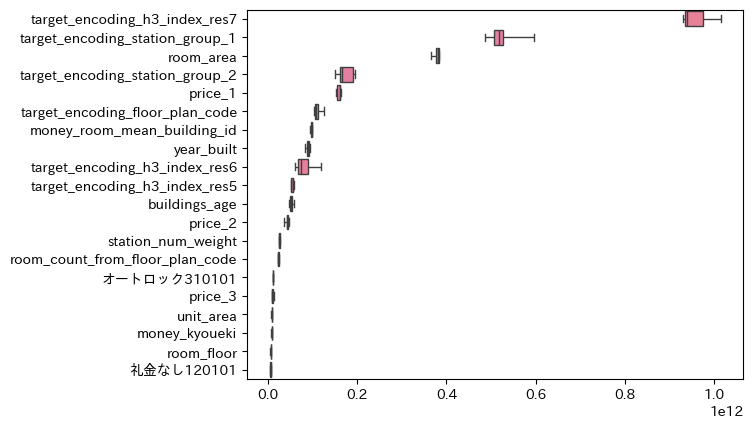

In [35]:
#表示
sns.boxplot(data=feature_importances_df, orient='h', order=order, whis=(0, 100));

#OOFの確認と重み最適化

In [36]:
#oofを作成
oof_df = train_df.clone()

for method in CFG.METHOD_LIST:
    tmp = pl.read_csv(CFG.OOF_DATA_PATH / f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv')
    oof_df = pl.concat([oof_df, tmp.select(pl.col(f'{method}_predictions'))], how='horizontal')

In [37]:
for method in CFG.METHOD_LIST:
    print(f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}')

oof_lightgbm_seed435_ver56
oof_xgboost_seed435_ver56
oof_catboost_seed435_ver56


In [38]:
#スコアを計算
for method in CFG.METHOD_LIST:
    oof_df = (oof_df.with_columns((pl.col(f'{method}_predictions') * pl.col('room_area')).alias(f'{method}_pred_money_room')))
    score = np.sqrt(mean_squared_error(oof_df.get_column('money_room'), oof_df.get_column(f'{method}_pred_money_room')))
    print(f'{method} CV RMSE is {score}')

lightgbm CV RMSE is 8656.834582225043
xgboost CV RMSE is 8710.435495711226
catboost CV RMSE is 8647.805330361647


In [39]:
# 予測値を抽出
y_true = oof_df.get_column('money_room').to_numpy()
lightgbm_pred = oof_df.get_column('lightgbm_pred_money_room').to_numpy()
xgboost_pred = oof_df.get_column('xgboost_pred_money_room').to_numpy()
catboost_pred = oof_df.get_column('catboost_pred_money_room').to_numpy()

In [40]:
# RMSE計算のための関数を定義
def calculate_rmse(weights):
    # 重み付き平均予測を計算
    weighted_pred = weights[0] * lightgbm_pred + weights[1] * xgboost_pred + weights[2] * catboost_pred
    # RMSEの計算
    rmse = np.sqrt(mean_squared_error(y_true, weighted_pred))
    return rmse

In [41]:
# 初期重み（すべて1に設定）
initial_weights = [1, 1, 1]

# 重みの合計が1になるように制約を設定
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# 最適化を実行
result = minimize(calculate_rmse, initial_weights, constraints=constraints, bounds=[(0, 1), (0, 1), (0, 1)])

# 最適な重みを表示
optimal_weights = result.x
print(f"Optimal weights: LightGBM: {optimal_weights[0]}, XGBoost: {optimal_weights[1]}, CatBoost: {optimal_weights[2]}")

# 最適化後のRMSEも表示
best_rmse = result.fun
print(f"Best RMSE: {best_rmse}")

Optimal weights: LightGBM: 0.35781859887208, XGBoost: 0.2923777597617806, CatBoost: 0.3498036413661394
Best RMSE: 8511.615395335835


In [42]:
optimal_weights_dict = {
    'lightgbm': optimal_weights[0],
    'xgboost': optimal_weights[1],
    'catboost': optimal_weights[2]
}

In [43]:
# 推論
test_df = mdl.Predicting(
    test_df,
    features,
    METHOD_LIST=CFG.METHOD_LIST,
    n_folds=CFG.n_folds,
    MODEL_DATA_PATH=CFG.MODEL_DATA_PATH,
    seed=CFG.seed,
    VER=CFG.VER,
    model_weight_dict=optimal_weights_dict,
)

100%|██████████| 3/3 [01:50<00:00, 36.85s/it]


In [44]:
# 後処理用のビルIDごとの平均値を追加
test_df = pre.join_money_room_over_building(train_df, pl.from_pandas(test_df))

In [45]:
test_df.head()

target_ym,building_id,building_status,building_type,building_name,unit_count,full_address,building_structure,floor_count,basement_floor_count,land_youto,land_toshi,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,room_floor,balcony_area,dwelling_unit_window_angle,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,flg_open,flg_own,bukken_type,empty_number,empty_contents,walk_distance1,flg_new,house_kanrinin,money_kyoueki,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_memo,genkyo_code,usable_status,usable_date,school_ele_distance,school_jun_distance,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,free_rent_duration,free_rent_gen_timing,year_built,lon,lat,addr1_1,addr1_2,unit_area,house_area,floor_plan_code,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,room_area,room_count_from_floor_plan_code,madori_from_floor_plan_code,target_year,target_month,month_built,buildings_age,money_room_mean_building_id,h3_index_res5,h3_index_res6,h3_index_res7,公営水道210101,井戸210102,水道その他210199,都市ガス210201,プロパンガス210202,ガスその他210299,下水210301,浄化槽210302,汲取210303,排水その他210399,オール電化210401,太陽光発電213101,スマートハウス213301,太陽光発電システム294201,オートロック310101,防犯カメラ310201,管理人常駐310301,24時間有人管理310401,セキュリティ充実313101,エレベーター320101,ごみ出し24時間OK320201,ペット用施設320301,フロントサービス320401,キッズルーム320501,駐車場あり320801,バイク置き場あり320901,駐輪場あり321001,宅配ボックス321101,コンシェルジュサービス323201,デザイナーズ330101,大規模マンション330201,低層マンション330401,タイル貼り330501,外断熱330601,低層住宅地333301,ハイグレードマンション333601,分譲物件333801,免震構造334001,耐震構造334101,制震構造334201,耐震・制震・免震構造334501,角地340301,南道路343201,敷地延長・変形地343301,環境にやさしい393101,子育てに優しい環境393201,スーパー800m以内410101,コンビニ400m以内410201,コンビニ 800ｍ以内410203,小学校800m以内420101,総合病院800m以内423103,公園400m以内423201,フィットネス施設（プール含む）800ｍ以内423301,中学校 800m以内423401,保育園・幼稚園 400m以内423501,複数路線433201,最寄り駅が始発駅433301,専用バス220101,共同バス220102,バスなし220103,専用トイレ220201,共同トイレ220202,トイレなし220203,バス・トイレ別220301,追い焚き220401,シャワー220501,洗髪洗面化粧台220601,温水洗浄便座220701,浴室乾燥機220801,浴室1.6×2.0M以上220901,独立洗面台223101,浴室TV223201,浴室窓有223301,浴室暖房223401,オートバス223501,高温差湯式223601,ガスコンロ設置済230101,電気コンロ230102,IHコンロ230103,コンロ一口230201,コンロ二口230202,コンロ三口230203,コンロ四口以上230204,システムキッチン230401,カウンターキッチン230501,食器洗い乾燥機230601,ディスポーザー230701,給湯230801,冷蔵庫あり230901,浄水器・活水器233101,ガスコンロ233201,冷房240101,ガス暖房240102,石油暖房240103,エアコン240104,床暖房240201,トランクルーム250101,床下収納250201,ウォークインクローゼット250301,パントリー253301,全居室収納253401,クローゼット253501,シューズボックス253601,シューズインクローゼット253701,CATV260101,CS対応260201,BS対応260301,有線放送260401,インターネット対応260501,高速インターネット260502,光ファイバー260503,インターネット利用料無料263101,CATV利用料無料263201,シングル＆DINKS向け283201,メゾネット283401,フローリング290101,専用庭290201,出窓290301,バルコニー290401,二世帯住宅向き290501,バリアフリー290601,フリーアクセス290701,ロフト付き290801,室内洗濯機置場290901,洗濯機置場あり290902,家具・家電付293101,ルーフバルコニー293301,内廊下293401,複層ガラス採用（二重サッシ・防犯サッシ等）293501,テラス293601,吹き抜け293801,和室294001,照明器具付294301,TVモニタ付インターホン310501,分譲賃貸331001,1階の物件340101,2階以上340102,最上階340201,角部屋340401,南向き340501,楽器相談110101,楽器不可110102,事務所可110201,事務所不可110202,二人入居可110301,二人入居不可110302,男性限定110401,女性限定110402,単身者限定110501,単身者希望110502,単身者不可110503,法人限定110601,法人希望110602,法人不可110603,学生限定110701,学生歓迎110702,高齢者限定110801,高齢者歓迎110802,ペット可110901,ペット相談110902,ペット不可110903,建築条件付き111001,建築条件なし111002,家賃カード決済可113301,初期費用カード決済可113302,家賃・初期費用カード決済可113303,ルームシェア可113401,ルームシェア不可113402,セキュリティ会社加入済み113501,フリーレント113601,カスタマイズ可113701,礼金なし120101,敷金なし120201,定期借家権120401,公庫利用可120501,手付金保証あり120601,家賃保証付き120801,保証人要121001,保証人不要121002,特優賃（特定優良賃貸住宅）121101,マンスリー可123201,住宅性能保証制度証明書330801,設計住宅性能評価書334801,耐震基準適合証明書335201,建築確認完了検査済証335501,BELS/省エネ基準適合認定建築物336501,station_group_1,station_group_2,station_group_3,station_name_1,station_name

In [46]:
def after_treatment(test_input:pl.DataFrame, model_pred_weight:float, train_id_weight):
    assert model_pred_weight + train_id_weight == 1, '重みの合計が1ではありません'

    out_put_series = (
        test_input
        .with_columns((
            # モデルの予測値から、部屋の賃料を求める
            pl.col('pred') * pl.col('room_area')).cast(pl.Int64).alias('pred_room_money'),
            # ビルごとの平均1平米賃料から、部屋の賃料を求める
            (pl.col('money_per_1m2_mean_building') * pl.col('room_area')).cast(pl.Int64).alias('room_money_from_building_mean1m2')
            )
        # idがtrainにあるものは重みづけを行い、ないものは予測値をそのまま用いる
        .with_columns(
            pl.when(pl.col('money_per_1m2_mean_building').is_not_nan())
            .then(((pl.col('pred_room_money') * model_pred_weight) + (pl.col('room_money_from_building_mean1m2') * train_id_weight)).alias('submit_pred'))
            .otherwise(pl.col('pred_room_money').alias('submit_pred'))
        )
    )
    return out_put_series

In [47]:
tmp = after_treatment(test_df, 1, 0)

In [48]:
submit_df = pd.read_csv('/workspace/data/sample_submit.csv', header=None)
submit_df[1] = (
    tmp
    .get_column('submit_pred')
    .to_pandas()
)
submit_df[1].isna().sum()

0

In [ ]:
# サブミットファイルを作成
submit_df.to_csv(CFG.SUB_DATA_PATH / f'seed{CFG.seed}_ver{CFG.VER}_{CFG.AUTHOR}_submission.csv', header=False, index=False)

In [50]:
pd.set_option("display.float_format", "{:.2f}".format)

In [51]:
submit_df.describe()

,0,1
count,384540.00,384540.00
mean,192269.50,57356.15
std,111007.28,30037.35
min,0.00,9769.00
25%,96134.75,40847.00
50%,192269.50,51673.00
75%,288404.25,65060.00
max,384539.00,1848262.00
